In [34]:
import pandas as pd
import numpy as np
import os, json, re, glob
from os.path import join
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater

from nilearn import image, plotting
from surfplot import Plot

from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti



# gradient color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import seaborn as sns

## functin: gradient color bar

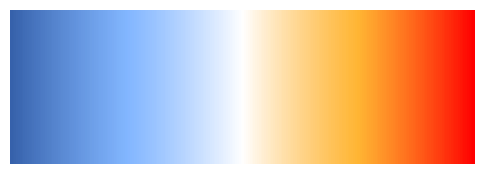

In [35]:
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


# gradient


# function for brain plot

In [61]:
# %%


def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(5000, 1000), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()


## stack xcorr data
previously, I had a bug where the dataframe was stacking sub-all.tsv. This led to an inflation in datapoints.
This bug is resolved by saving the file in a different folder, no longer being globbed and concatenated

In [37]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/xcorr_noZ'

all_frames = []  
xcorr_flist = glob.glob(join(xcorr_dir, f"sub-*_ses-*_run*_runtype-pain_xcorr-fmri-physio.tsv"))
for xcorr_fname in xcorr_flist:
# for filename in os.listdir(xcorr_dir):
    if xcorr_fname.endswith('.tsv'):  # Assuming the files are CSVs
        # file_path = os.path.join(xcorr_dir, filename)
        df = pd.read_csv(xcorr_fname, sep='\t')
        all_frames.append(df)
combined_df = pd.concat(all_frames, ignore_index=True)
combined_df.to_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t', index=False)


In [38]:
xcorr_fname

'/Volumes/spacetop_projects_cue/analysis/physio/xcorr_noZ/sub-0133_ses-01_run-03_runtype-pain_xcorr-fmri-physio.tsv'

In [39]:
combined_df = pd.read_csv(join(xcorr_dir, 'total', 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t')


In [40]:
# remove unnecessary columns and rows with NA values
df = combined_df.drop(columns=['Unnamed: 0'])
df = df.dropna()
df.head()

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s)
0,sub-0061,ses-04,run-03,0,0.015488,-4.14
1,sub-0061,ses-04,run-03,1,0.010691,-10.12
2,sub-0061,ses-04,run-03,2,0.022655,27.14
3,sub-0061,ses-04,run-03,3,0.020641,20.24
4,sub-0061,ses-04,run-03,4,0.018622,19.32


In [41]:
len(df)

133600

In [42]:
# Counting frequency of each 'sub' value
frequency = df.groupby('sub').size().reset_index(name='xcorr_frequency_including_400roi')
frequency['run_freq'] = frequency['xcorr_frequency_including_400roi'] / 400


In [43]:
sum(frequency.run_freq)/78

4.282051282051282

In [44]:
frequency

,sub,xcorr_frequency_including_400roi,run_freq
0,sub-0015,800,2.0
1,sub-0016,2000,5.0
2,sub-0017,800,2.0
3,sub-0026,1200,3.0
4,sub-0028,800,2.0
...,...,...,...
73,sub-0128,1600,4.0
74,sub-0129,2400,6.0
75,sub-0131,1600,4.0
76,sub-0132,2400,6.0


In [45]:
frequency.run_freq.min()

1.0

In [78]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10 

min: -0.0105589330527896, max:0.3196946691205458


Text(0.5, 1.0, 'Distribution of cross-correlation values\nMin: -0.011,  Max: 0.32')

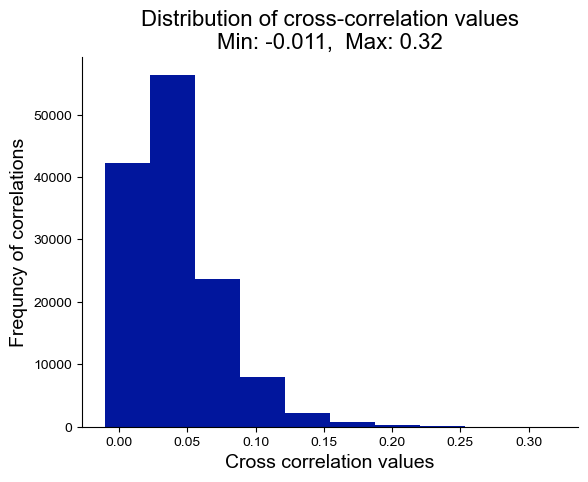

In [85]:
plt.hist(df['Maximum Correlation Value'], color='#01169D')
print(f"min: {df['Maximum Correlation Value'].min()}, max:{df['Maximum Correlation Value'].max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values\nMin: {round(df['Maximum Correlation Value'].min(), 3)},  Max: {round(df['Maximum Correlation Value'].max(), 3)}", fontsize=16)



## fisher z transform

In [47]:
def fisher_z_transform(r):
    return np.arctanh(r)

df['Max_Corr_Value_Z']  = df.groupby('sub')['Maximum Correlation Value'].transform(fisher_z_transform)
# df['Max_Corr_Value_Z'] = df['Maximum Correlation Value'].apply(fisher_z_transform)


In [48]:
df

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0061,ses-04,run-03,0,0.015488,-4.14,0.015490
1,sub-0061,ses-04,run-03,1,0.010691,-10.12,0.010691
2,sub-0061,ses-04,run-03,2,0.022655,27.14,0.022659
3,sub-0061,ses-04,run-03,3,0.020641,20.24,0.020644
4,sub-0061,ses-04,run-03,4,0.018622,19.32,0.018624
...,...,...,...,...,...,...,...
133595,sub-0133,ses-01,run-03,395,0.046390,16.10,0.046423
133596,sub-0133,ses-01,run-03,396,0.020235,15.64,0.020238
133597,sub-0133,ses-01,run-03,397,0.019442,-3.22,0.019445
133598,sub-0133,ses-01,run-03,398,0.028642,16.10,0.028650


## calculate summary statistics
here, I average Maximum corr values, time lags 
* first by calculating 1) within runs, 
* then 2) aggregating corr values, time lags per roi averaged within subs, 
* then 3) group level stats per ROI

In [49]:
avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_91750/300525674.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_91750/300525674.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()


In [50]:
avg_per_sub

,sub,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0015,0,0.036188,-6.44,0.036205
1,sub-0015,1,0.068857,9.43,0.068983
2,sub-0015,2,0.100687,12.65,0.101180
3,sub-0015,3,0.095407,13.57,0.095933
4,sub-0015,4,0.114560,13.57,0.115505
...,...,...,...,...,...
31195,sub-0133,395,0.055336,19.09,0.055430
31196,sub-0133,396,0.045275,16.33,0.045306
31197,sub-0133,397,0.037381,16.33,0.037399
31198,sub-0133,398,0.054733,23.46,0.054816


In [51]:
import pandas as pd
import scipy.stats

# Assuming df is your DataFrame

# Define a list to store the results
results = []

# Group by 'roi' and run t-test on each group
for roi, group in avg_per_sub.groupby('roi'):
    # Extract the 'Maximum Correlation Value' for the current group
    values = group['Maximum Correlation Value']
    
    # Perform the one-sample t-test against the population mean of 0
    t, p = scipy.stats.ttest_1samp(values, popmean=0)
    
    # Append the results for the current ROI
    results.append({'roi': roi, 
    't-value': t, 
    'p-value': p, 
    'mean_xcor': np.tanh(np.nanmean(values, axis=0))
    })

# Convert the results list into a DataFrame
results_df = pd.DataFrame(results)

# Show or save the results
print(results_df)


     roi    t-value       p-value  mean_xcor
0      0  17.397864  2.124097e-28   0.035833
1      1  15.715609  9.759732e-26   0.035792
2      2  19.686298  8.804054e-32   0.041316
3      3  20.103351  2.271904e-32   0.036921
4      4  18.300398  9.145144e-30   0.040656
..   ...        ...           ...        ...
395  395  19.337470  2.774743e-31   0.041338
396  396  20.615208  4.422750e-33   0.038396
397  397  19.639429  1.026410e-31   0.035433
398  398  21.886733  8.558796e-35   0.042159
399  399  19.940017  3.852927e-32   0.039710

[400 rows x 4 columns]


In [70]:
# non_significant = results_df[results_df['p-value'] <= 0.05]
# non_significant
from statsmodels.stats.multitest import multipletests

p_adjusted = multipletests(results_df['p-value'], alpha=0.05, method='fdr_bh')
p_adjusted

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

In [76]:
adjusted_p_values = p_adjusted[2]
adjusted_p_values

0.00012822501443887635

In [53]:

group_level_avg = avg_per_sub.groupby('roi').median().reset_index()
group_level_avg['Avg_Max_Corr_Value'] = np.tanh(group_level_avg['Max_Corr_Value_Z'])

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_91750/1833794885.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_level_avg = avg_per_sub.groupby('roi').median().reset_index()


In [54]:
group_level_avg.head()

,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z,Avg_Max_Corr_Value
0,0,0.032894,10.2350,0.032914,0.032902
1,1,0.033896,8.9700,0.033925,0.033912
2,2,0.040096,9.0850,0.040149,0.040127
3,3,0.034049,8.4525,0.034072,0.034058
4,4,0.039678,8.9700,0.039728,0.039707


In [55]:
df.head()

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0061,ses-04,run-03,0,0.015488,-4.14,0.015490
1,sub-0061,ses-04,run-03,1,0.010691,-10.12,0.010691
2,sub-0061,ses-04,run-03,2,0.022655,27.14,0.022659
3,sub-0061,ses-04,run-03,3,0.020641,20.24,0.020644
4,sub-0061,ses-04,run-03,4,0.018622,19.32,0.018624


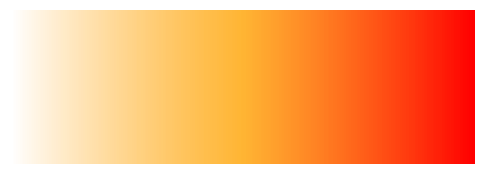

In [56]:
# Define the colors at specific points
colors = [
    # (-1, "#120041"),  # Start with blue at -1.9
    # (-0.8, "#2500fa"),
    # (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.01, "#d50044"),
    (0.02, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (0.03, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-1, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-0.8, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (.02, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (0.03, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, .064, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
xcorr_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=xcorr_cmap)
ax.set_axis_off()

plt.show()


# plot X corr

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


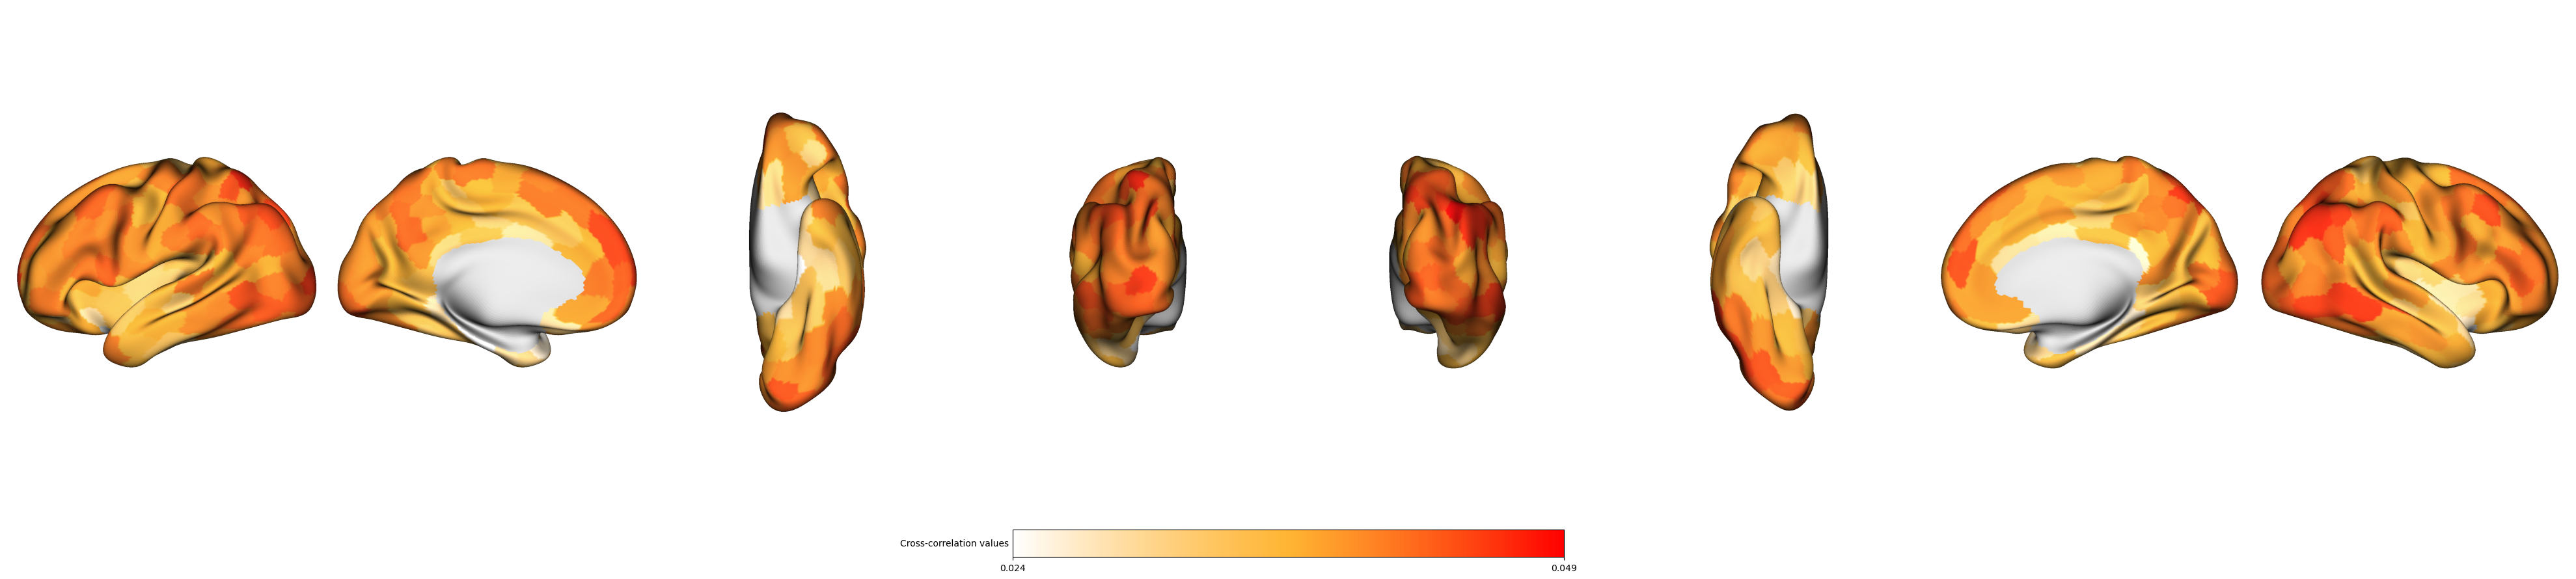

<Figure size 640x480 with 0 Axes>

In [62]:
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_avg['Avg_Max_Corr_Value']
roidata = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
fig = plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
plt.show()
plt.savefig('Xcorr.png', dpi=300)  # Increase DPI for higher resolution


min: 0.023783572540674456, max:0.04853193019015286


Text(0.5, 1.0, 'Distribution of cross-correlation values (summary statistics)\nMin: 0.024,  Max: 0.049')

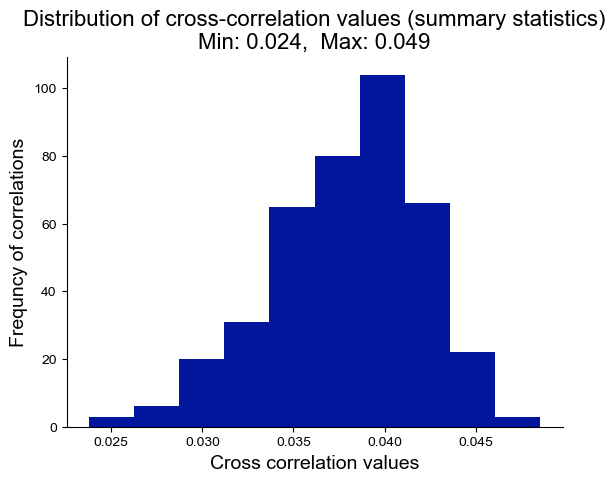

In [86]:
plt.hist(roi_xcorr)
plt.hist(roi_xcorr, color='#01169D')
print(f"min: {roi_xcorr.min()}, max:{roi_xcorr.max()}")
sns.despine()
plt.xlabel('Cross correlation values', fontsize=14)
plt.ylabel('Frequncy of correlations', fontsize=14)
plt.title(f"Distribution of cross-correlation values (summary statistics)\nMin: {round(roi_xcorr.min(), 3)},  Max: {round(roi_xcorr.max(), 3)}", fontsize=16)



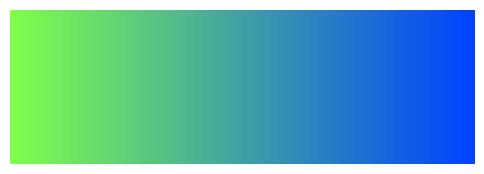

In [66]:
# Define the colors at specific points
colors = [
    # (-5.4, "#120041"),  # Start with blue at -1.9
    # (-3.6, "#2500fa"),
    # (-1.8, "#84c6fd"),  # Start with blue at -1.9
    (0, "#80ff4a"),    # Transition to white at 0
    # (4, "#fdbb2d"),
    # (5, "#09792c"),    # Start transitioning to red just after 0 towards 1.2
    (12, "#0043ff")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-5.4, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-3.6, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("#80ff4a", alpha=1.0)),       # Fully opaque
    # (4, to_rgba("#fdbb2d", alpha=0.6)),   # 30% opacity
    # (6, to_rgba("#09792c", alpha=0.8)),   # 60% opacity
    (12, to_rgba("#0043ff", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0,12, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
lag_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=lag_cmap)
ax.set_axis_off()

plt.show()


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


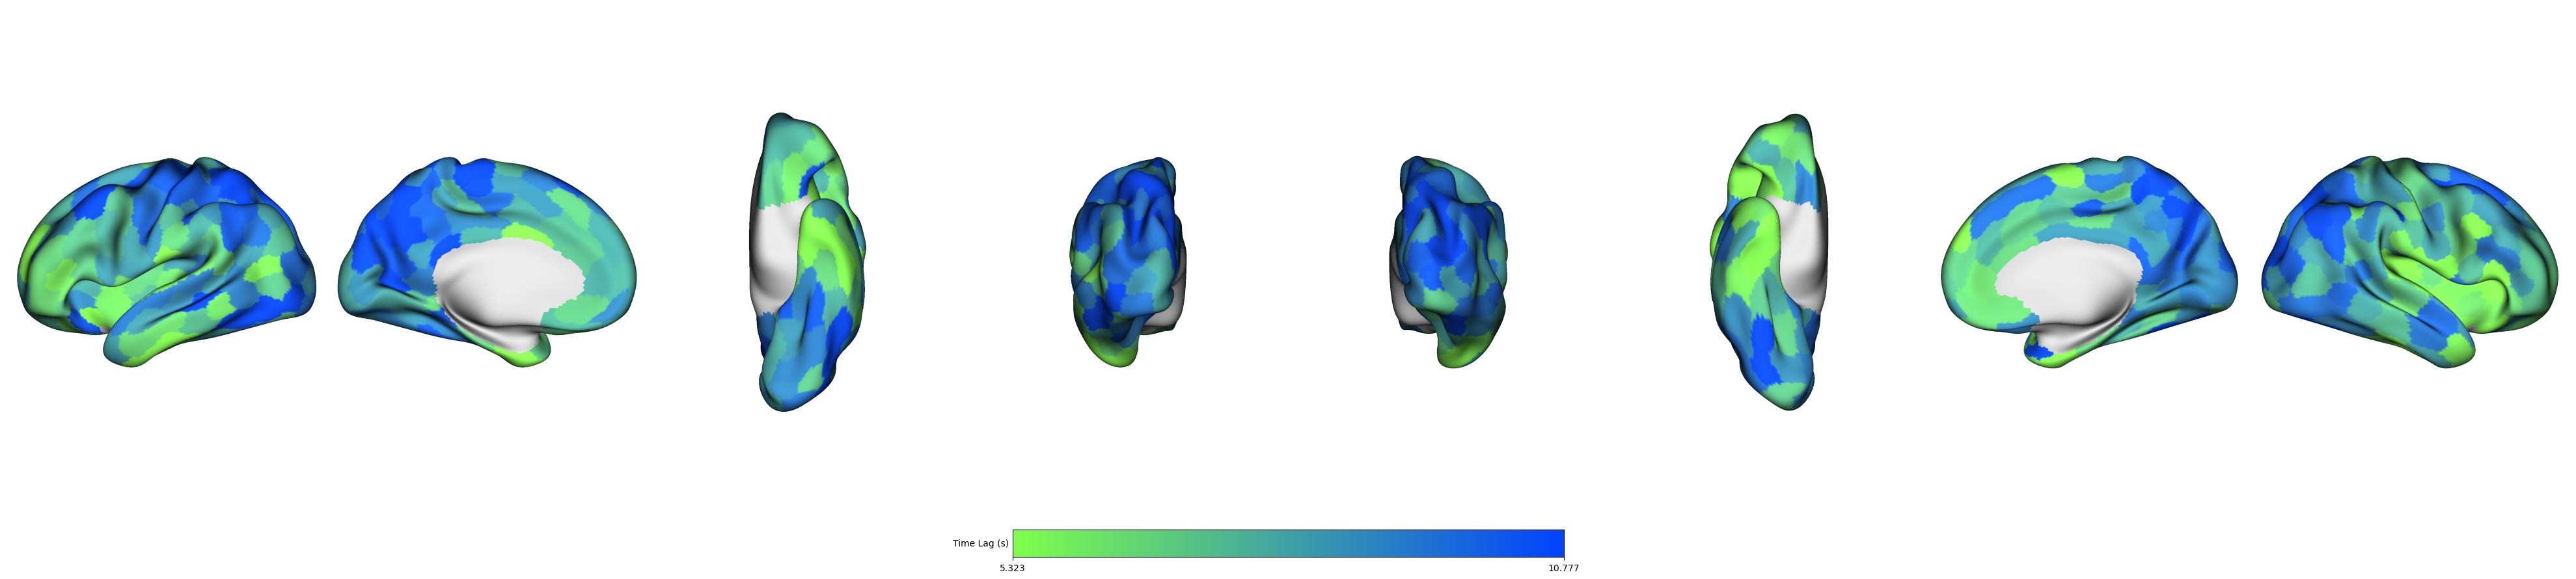

In [67]:
# xcorr_fname = 
# group_level_avg  =pd.read_csv(xcorr_fname, '\t')

schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_timelag = group_level_avg['Time Lag (s)']
roidata = parc.inverse_transform(roi_timelag)

maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
plot_brain_surfaces(image=roidata, cbar_label='Time Lag (s)', cmap=lag_cmap, color_range=(minval+sd, maxval-sd))
plt.show()